In [1]:
!pip install matplotlib
!pip install opencv-python
!pip install scikit-image
!pip install wheel
!pip install pandas
!pip install scikit-learn scipy
!pip install keras
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


556


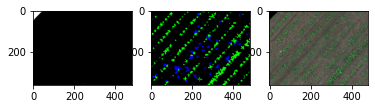

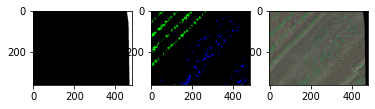

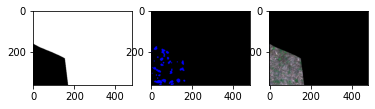

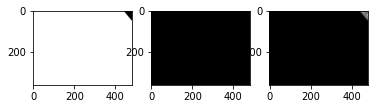

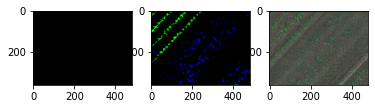

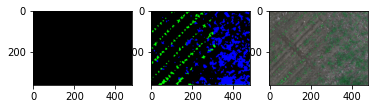

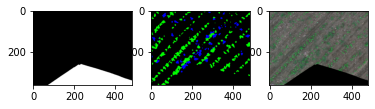

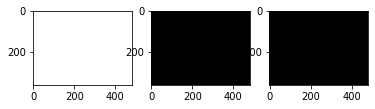

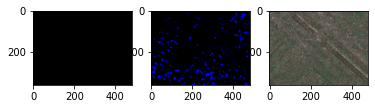

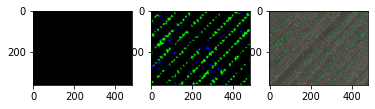

In [2]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir
from skimage import io

#specifying paths
path1='/storage/phucpg/test1/RedEdge_filtered/mask/'
path2='/storage/phucpg/test1/RedEdge_filtered/color/'
path3='/storage/phucpg/test1/RedEdge_filtered/RGB/'
print(len(listdir(path1)))

#printing the first 10 files
for filename in listdir(path1)[:10]:
  
  image_r=cv2.imread(path1 + filename)
  # image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,1)
  plt.imshow(image_r)

  image_r=cv2.imread(path2 + filename)
  # image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,2)
  plt.imshow(image_r)
  # print(image_r[:,:,2])
  # print(np.count_nonzero(image_r[:,:,2]))

  image_r=cv2.imread(path3 + filename)
  image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,3)
  plt.imshow(image_r)
  
  plt.show()

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split
import gc; gc.enable() # memory is tight

from keras import layers, models
from keras import backend as K
from tensorflow.keras.optimizers import Adam

N=556
TRAIN_SIZE=500
TEST_SIZE=56
BATCH_SIZE = 10
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 552
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
resized_shape=(256,256)
train_mask=[]
test_mask=[]
train_images=[]
test_images=[]
for i,file in enumerate(listdir(path1)):
  if i<TRAIN_SIZE:
    train_images.append(path3+file)
    train_mask.append(path2+file)

  else:
    test_images.append(path3+file)
    test_mask.append(path2+file)
df_train=pd.DataFrame(np.column_stack([train_images,train_mask]),columns=['images','masks'])
df_test=pd.DataFrame(np.column_stack([test_images,test_mask]),columns=['images','masks'])

df1 = df_train.sort_values(by='images')['images'].reset_index()
df2 = df_train.sort_values(by='masks')['masks'].reset_index()
# df2 = df.sort_values(by='b')['b']
df_train['images'] = df1['images']
df_train['masks'] = df2['masks']
del df1, df2

df1 = df_test.sort_values(by='images')['images'].reset_index()
df2 = df_test.sort_values(by='masks')['masks'].reset_index()
# df2 = df.sort_values(by='b')['b']
df_test['images'] = df1['images']
df_test['masks'] = df2['masks']
del df1, df2

2022-07-13 06:54:13.013870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/phucpg/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-13 06:54:13.013901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Checking size of training dataframe
len(df_train)
df_train

,images,masks
0,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
1,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
2,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
3,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
4,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
...,...,...
495,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
496,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
497,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
498,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...


In [5]:
# Checking size of testing dataframe
len(df_test)
df_test

,images,masks
0,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
1,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
2,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
3,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
4,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
5,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
6,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
7,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
8,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...
9,/storage/phucpg/test1/RedEdge_filtered/RGB/fra...,/storage/phucpg/test1/RedEdge_filtered/color/f...


In [6]:
def create_mask(maskpath,img_shape):
  mask=np.zeros(shape=(img_shape[0],img_shape[1],1))
  mask_img=cv2.imread(maskpath)
  mask_img=mask_img[:,:,2]
  for i in range(img_shape[0]):
    for j in range(img_shape[1]):
      if mask_img[i,j]>0:
        mask[i,j,0]=1
      else:
        mask[i,j,0]=0
  return mask

def create_images_generator(df_in, batch_size, resized_shape):
  batch_image = []
  batch_mask = []
  df_in_list = (df_in).values.tolist()
  # np.random.shuffle(df_in_list) 
    
  while True:
      for image_path, mask_path in df_in_list:
        
        image_r = cv2.imread(image_path)
        image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
        mask_r = create_mask(mask_path, image_r.shape)
        # print("shape is ",image_r.shape) is 360x480
        image_r = cv2.resize(image_r,(resized_shape[1], resized_shape[0]))
        mask_r = cv2.resize(mask_r,(resized_shape[1], resized_shape[0]))          
                    
        batch_image.append(image_r)
        batch_mask.append(mask_r)
        
        if len(batch_mask)>=batch_size:
            yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.float32(np.expand_dims(batch_mask, -1)), 0)
            batch_image, batch_mask = [], []

In [7]:
from keras.preprocessing.image import ImageDataGenerator
args_dg = dict(featurewise_center = False, 
               samplewise_center = False, 
               rotation_range = 2, 
               width_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.1], 
               horizontal_flip = False, 
               vertical_flip = False,
               fill_mode = 'constant',
               data_format = 'channels_last')

if AUGMENT_BRIGHTNESS:
    args_dg['brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**args_dg)

if AUGMENT_BRIGHTNESS:
    args_dg.pop('brightness_range')
mask_gen = ImageDataGenerator(**args_dg)

In [8]:
# In[]
def make_augment_generator(img_mask_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img_in, mask_in in img_mask_gen:
        seed = np.random.choice(range(9999))
        aug_img_in = image_gen.flow(255*img_in, 
                                 batch_size=img_in.shape[0],
                                 seed = seed, 
                                 shuffle=True)
        aug_mask_in = mask_gen.flow(mask_in, 
                                    batch_size=img_in.shape[0],
                                    seed=seed,
                                    shuffle=True)
        yield next(aug_img_in)/255.0, next(aug_mask_in)

In [9]:
def calc_IOU(y_true, y_pred, smooth=1):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)    
    intersection = K.sum(y_true_f*y_pred_f)
    
    return (2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def calc_IOU_loss(y_true, y_pred):
    return 1-calc_IOU(y_true, y_pred)


In [10]:
# In[]
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

def create_unet():
    
    # input_img = layers.Input(batch_img.shape[1:], name = 'RGB_Input')
    input_img = layers.Input((resized_shape[0],resized_shape[1],3), name = 'RGB_Input')
    pp_in_layer = input_img
             
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    
    u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=3)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=3)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=3)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)
    
    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)   
    if NET_SCALING is not None:
      d = layers.UpSampling2D(NET_SCALING)(d)
     
    seg_model = models.Model(inputs=[input_img], outputs=[d])
    seg_model.summary()
    
    return seg_model

In [11]:
# In[]

model = create_unet()
model.compile(optimizer=Adam(lr=1e-3),
              loss=calc_IOU_loss, metrics=[calc_IOU])
# In[]
# history = model.fit_generator(train_gen,
#             samples_per_epoch=40,
#                               nb_epoch=2)    
 
train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
valid_gen = create_images_generator(df_test, batch_size=BATCH_SIZE, resized_shape=resized_shape)
# aug_gen = make_augment_generator(train_gen)
val_img, val_mask = next(valid_gen)  


2022-07-13 06:54:35.171533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/phucpg/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-13 06:54:35.171650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/phucpg/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-13 06:54:35.171736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/phucpg/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-13 06:54:35.174628: W tensorflow/stream_executor/platform

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['RGB_Input[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d_1[0][0]']           

/home/phucpg/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
#UNCOMMENT IF NO CHECKPOINT MODEL AVAILABLE
history=model.fit_generator(train_gen,
 steps_per_epoch=5,
 epochs=200,
 validation_data=(val_img, val_mask) )

/tmp/ipykernel_24313/305255100.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,


Epoch 1/200
5/5 [==============================] - 19s 4s/step - loss: 0.8877 - calc_IOU: 0.1123 - val_loss: 0.9307 - val_calc_IOU: 0.0693
Epoch 2/200
5/5 [==============================] - 16s 4s/step - loss: 0.9308 - calc_IOU: 0.0692 - val_loss: 0.9295 - val_calc_IOU: 0.0705
Epoch 3/200
5/5 [==============================] - 17s 4s/step - loss: 0.9345 - calc_IOU: 0.0655 - val_loss: 0.9273 - val_calc_IOU: 0.0727
Epoch 4/200
5/5 [==============================] - 17s 4s/step - loss: 0.9789 - calc_IOU: 0.0211 - val_loss: 0.9233 - val_calc_IOU: 0.0767
Epoch 5/200
5/5 [==============================] - 17s 3s/step - loss: 0.9873 - calc_IOU: 0.0127 - val_loss: 0.9212 - val_calc_IOU: 0.0788
Epoch 6/200
5/5 [==============================] - 17s 4s/step - loss: 0.9265 - calc_IOU: 0.0735 - val_loss: 0.9209 - val_calc_IOU: 0.0791
Epoch 7/200
5/5 [==============================] - 18s 4s/step - loss: 0.9749 - calc_IOU: 0.0251 - val_loss: 0.9211 - val_calc_IOU: 0.0789
Epoch 8/200
5/5 [==========

5/5 [==============================] - 18s 4s/step - loss: 0.8603 - calc_IOU: 0.1397 - val_loss: 0.7701 - val_calc_IOU: 0.2299
Epoch 60/200
5/5 [==============================] - 18s 4s/step - loss: 0.8079 - calc_IOU: 0.1921 - val_loss: 0.6446 - val_calc_IOU: 0.3554
Epoch 61/200
5/5 [==============================] - 18s 4s/step - loss: 0.7759 - calc_IOU: 0.2241 - val_loss: 0.6503 - val_calc_IOU: 0.3497
Epoch 62/200
5/5 [==============================] - 18s 4s/step - loss: 0.7341 - calc_IOU: 0.2659 - val_loss: 0.7181 - val_calc_IOU: 0.2819
Epoch 63/200
5/5 [==============================] - 18s 4s/step - loss: 0.5813 - calc_IOU: 0.4187 - val_loss: 0.7114 - val_calc_IOU: 0.2886
Epoch 64/200
5/5 [==============================] - 18s 4s/step - loss: 0.8890 - calc_IOU: 0.1110 - val_loss: 0.6691 - val_calc_IOU: 0.3309
Epoch 65/200
5/5 [==============================] - 18s 4s/step - loss: 0.9130 - calc_IOU: 0.0870 - val_loss: 0.6439 - val_calc_IOU: 0.3561
Epoch 66/200
5/5 [===============

5/5 [==============================] - 18s 4s/step - loss: 0.8412 - calc_IOU: 0.1588 - val_loss: 0.5362 - val_calc_IOU: 0.4638
Epoch 118/200
5/5 [==============================] - 18s 4s/step - loss: 0.7344 - calc_IOU: 0.2656 - val_loss: 0.5143 - val_calc_IOU: 0.4857
Epoch 119/200
5/5 [==============================] - 18s 4s/step - loss: 0.5907 - calc_IOU: 0.4093 - val_loss: 0.5015 - val_calc_IOU: 0.4985
Epoch 120/200
5/5 [==============================] - 18s 4s/step - loss: 0.6172 - calc_IOU: 0.3828 - val_loss: 0.5074 - val_calc_IOU: 0.4926
Epoch 121/200
5/5 [==============================] - 18s 4s/step - loss: 0.4343 - calc_IOU: 0.5657 - val_loss: 0.5071 - val_calc_IOU: 0.4929
Epoch 122/200
5/5 [==============================] - 18s 4s/step - loss: 0.5562 - calc_IOU: 0.4438 - val_loss: 0.5248 - val_calc_IOU: 0.4752
Epoch 123/200
5/5 [==============================] - 18s 4s/step - loss: 0.3987 - calc_IOU: 0.6013 - val_loss: 0.4958 - val_calc_IOU: 0.5042
Epoch 124/200
5/5 [========

5/5 [==============================] - 17s 4s/step - loss: 0.6657 - calc_IOU: 0.3343 - val_loss: 0.7423 - val_calc_IOU: 0.2577
Epoch 176/200
5/5 [==============================] - 18s 4s/step - loss: 0.5370 - calc_IOU: 0.4630 - val_loss: 0.4627 - val_calc_IOU: 0.5373
Epoch 177/200
5/5 [==============================] - 18s 4s/step - loss: 0.7662 - calc_IOU: 0.2338 - val_loss: 0.4902 - val_calc_IOU: 0.5098
Epoch 178/200
5/5 [==============================] - 18s 4s/step - loss: 0.6380 - calc_IOU: 0.3620 - val_loss: 0.5803 - val_calc_IOU: 0.4197
Epoch 179/200
5/5 [==============================] - 17s 4s/step - loss: 0.5541 - calc_IOU: 0.4459 - val_loss: 0.4858 - val_calc_IOU: 0.5142
Epoch 180/200
5/5 [==============================] - 18s 4s/step - loss: 0.5708 - calc_IOU: 0.4292 - val_loss: 0.4839 - val_calc_IOU: 0.5161
Epoch 181/200
5/5 [==============================] - 17s 4s/step - loss: 0.3833 - calc_IOU: 0.6167 - val_loss: 0.4766 - val_calc_IOU: 0.5234
Epoch 182/200
5/5 [========

In [13]:
print(1)

1


1/1 [==============================] - 0s 137ms/step - loss: 0.4882 - calc_IOU: 0.5118
The accuracy is 
[0.4881543517112732, 0.5118456482887268]


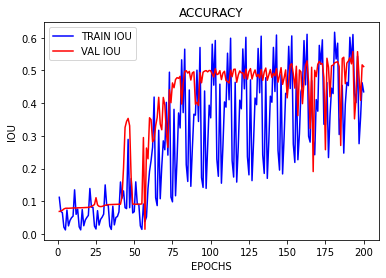

In [14]:
#plot

results=model.evaluate(val_img,val_mask)
print("The accuracy is ")
print(results)
acc=history.history['calc_IOU']
val_acc=history.history['val_calc_IOU']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'-b',label="TRAIN IOU")
plt.plot(epochs,val_acc,'-r',label="VAL IOU")
plt.title("ACCURACY")
plt.xlabel("EPOCHS")
plt.ylabel("IOU")
plt.legend()
plt.show()

In [15]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
print(2) 

2
